In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline


import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
# loading datasets

trainData = pd.read_csv('train_E1GspfA.csv')
testData = pd.read_csv('test_6QvDdzb.csv')

In [3]:
trainData.shape,testData.shape

((18247, 3), (7650, 2))

* The trainData has 18247 Rows and 3 columns and testData has 7650 Rows and 2 columns.

## 1. Data Inspection

### Checking whether the data has Null values

In [4]:
trainData.isna().sum()

date      0
hour      0
demand    0
dtype: int64

In [5]:
testData.isna().sum()

date    0
hour    0
dtype: int64

* Both the Train and Test Datasets does not have any null values

In [6]:
# Checking the duplicate observations

trainDuplicated = trainData[trainData.duplicated()]
trainDuplicated

,date,hour,demand


In [7]:
testDuplicated = testData[testData.duplicated()]
testDuplicated

,date,hour


* There are no duplicate rows in both the data sets

In [8]:
trainData.head()

,date,hour,demand
0,2018-08-18,9,91
1,2018-08-18,10,21
2,2018-08-18,13,23
3,2018-08-18,14,104
4,2018-08-18,15,81


In [9]:
testData.head()

,date,hour
0,2021-03-01,0
1,2021-03-01,1
2,2021-03-01,2
3,2021-03-01,3
4,2021-03-01,5


In [10]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18247 entries, 0 to 18246
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    18247 non-null  object
 1   hour    18247 non-null  int64 
 2   demand  18247 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 427.8+ KB


In [11]:
testData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7650 entries, 0 to 7649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    7650 non-null   object
 1   hour    7650 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.7+ KB


In [12]:
#2. converting hour column to object since it is int64

trainData['hour'] = trainData['hour'].astype('object')
testData['hour'] = testData['hour'].astype('object')

## 2. Exploratory Data Analysis

### Visual Analysis

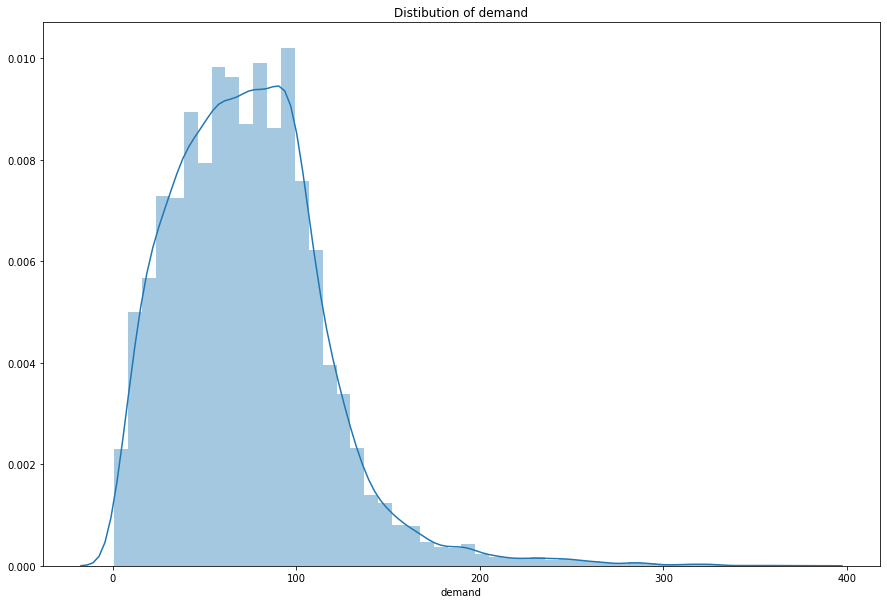

In [13]:
sns.distplot(trainData['demand'], kde = True).set_title('Distibution of demand')
plt.gcf().set_size_inches(15,10)

* There is right skew in the distribution.
* we can conclude that demand is normally distributed as we can see the bell curve.

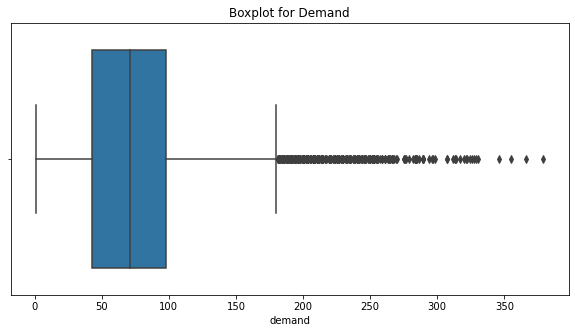

In [14]:
# so we can see the outliers in demand column in trainData as there is +ve skew
# further inspecting using boxplot

sns.boxplot(trainData['demand']).set_title('Boxplot for Demand')
plt.gcf().set_size_inches(10,5)

In [15]:
# Further inspecting the demand variable using percentiles at different levels

percentile_list = [10, 25, 50, 70, 80, 90, 95, 99]              # created the list for the percentiles
percentile_value = [np.percentile(trainData['demand'],10),
                    np.percentile(trainData['demand'],25),
                    np.percentile(trainData['demand'],50),
                    np.percentile(trainData['demand'],70),
                    np.percentile(trainData['demand'],80),
                    np.percentile(trainData['demand'],90),
                    np.percentile(trainData['demand'],95),
                    np.percentile(trainData['demand'],99)
                   ]                                        # created list for the percentile value, so that both
                                                            # lists can be merged to make easy for visualization
    
percentile_list = pd.DataFrame(percentile_list, columns = ['Percentile']) #converting to pandas DF
percentile_value = pd.DataFrame(percentile_value, columns = ['Value'])
percentile_df = pd.concat([percentile_list, percentile_value],axis = 1)   # merge 2 above DFs

percentile_df

,Percentile,Value
0,10,24.0
1,25,43.0
2,50,71.0
3,70,93.0
4,80,103.0
5,90,122.0
6,95,142.0
7,99,211.0


* As we can see 95 %ile of values are under 142. so we treat values above 95%ile as outliers.

In [16]:
# removing outliers

trainData = trainData[(trainData['demand'] <= 142)]
trainData.reset_index(drop = True, inplace = True)     # Resetting the index

In [17]:
from datetime import datetime

# for more granularity we extract day of the week, month and day

trainData['date'] = pd.to_datetime(trainData['date'])         # converting to datetime
trainData2 = trainData.copy()                                 # making deep copy of dataset to do Visual Analysis
trainData2['dayOfWeek'] = trainData2['date'].dt.day_name()    # day of the week
trainData2['month'] = trainData2['date'].dt.month
trainData2['day'] = trainData2['date'].dt.day

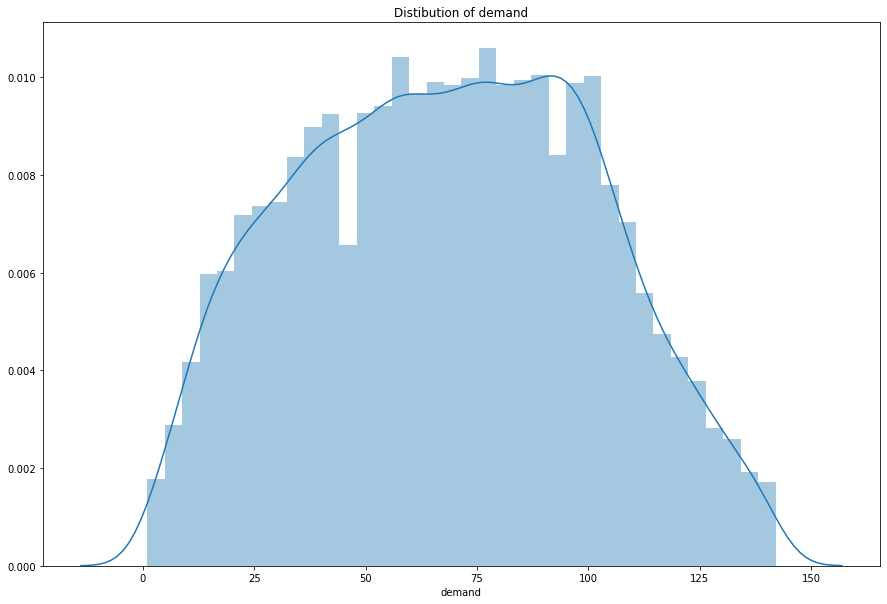

In [18]:
# now checking the distribution

sns.distplot(trainData2['demand'], kde = True).set_title('Distibution of demand')
plt.gcf().set_size_inches(15, 10)

* Now the distribution looks normal so far and there is no skew.

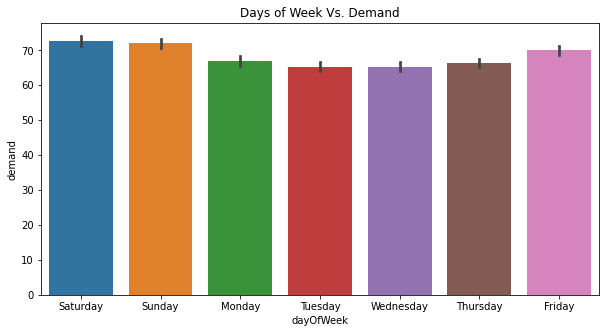

In [19]:
sns.barplot(x = 'dayOfWeek', y = 'demand', data = trainData2).set_title('Days of Week Vs. Demand')
plt.gcf().set_size_inches(10,5)

* sundays and Saturdays have more demands.

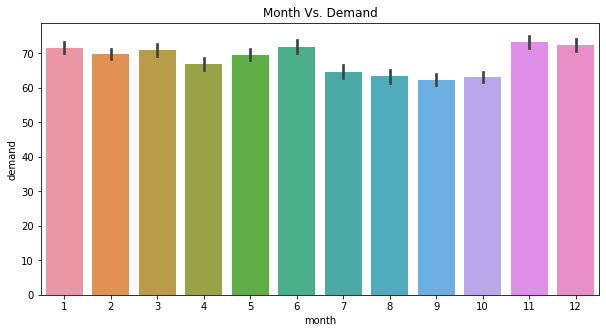

In [20]:
sns.barplot(x = 'month', y = 'demand', data = trainData2).set_title('Month Vs. Demand')
plt.gcf().set_size_inches(10,5)

* There are more demands in the month of November and June.

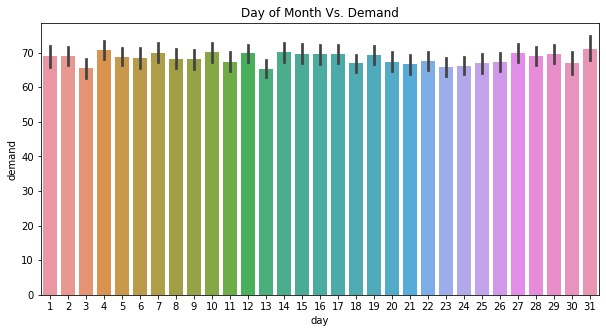

In [21]:
sns.barplot(x = 'day', y = 'demand', data = trainData2).set_title('Day of Month Vs. Demand')
plt.gcf().set_size_inches(10,5)

* demands are significantly increasing from 4th day of the month and demand is decreasing from 11th day.
* and same pattern is followed and demands are increasing during the month ends.

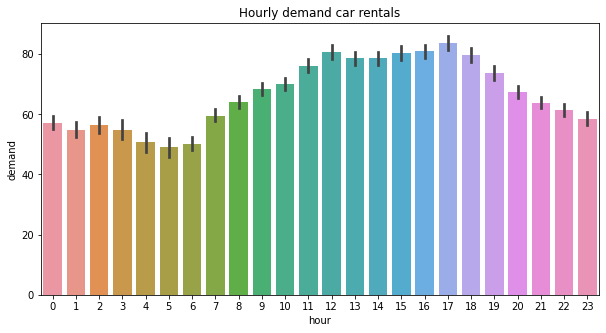

In [22]:
sns.barplot(x = 'hour', y = 'demand', data = trainData2).set_title('Hourly demand car rentals')
plt.gcf().set_size_inches(10,5)

* Demands are high dring 11:00 am to 6:00 pm

## 3. Data preprocessing

In [23]:
# Level Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
var_mod = trainData.select_dtypes(include = 'object').columns
for i in var_mod:
    trainData[i] = le.fit_transform(trainData[i])
for i in var_mod:
    testData[i] = le.fit_transform(testData[i])

In [24]:
# Separating target variable and features
X = trainData.drop(columns= ['demand'], axis = 1)
y = trainData['demand']

In [25]:
#splitting train/test ratio to 70:30, 30% as validation set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.3,
                                                   random_state = 52)

In [26]:
X_train['date'] = X_train['date'].map(datetime.toordinal)
X_test['date'] = X_test['date'].map(datetime.toordinal)

In [27]:
X_train.head()

,date,hour
8015,737350,9
4612,737168,1
12230,737562,1
15518,737729,0
5652,737221,22


In [28]:
# model building
from sklearn.linear_model import LinearRegression

demand_lm = LinearRegression(normalize = True)

In [29]:
demand_lm.fit(X_train, y_train)

LinearRegression(normalize=True)

In [30]:
y_pred = demand_lm.predict(X_test)

In [31]:
from sklearn import metrics

MSE= metrics.mean_squared_error(y_test,y_pred)
from math import sqrt
rmse = sqrt(MSE)
print("Root Mean Squared Error:",rmse)

Root Mean Squared Error: 32.54176478599998


In [32]:
testData['date'] = pd.to_datetime(testData['date']) # converting to date
testData['date'] = testData['date'].map(datetime.toordinal) # converting to ord so that logistic reg would work

In [33]:
submission = pd.read_csv('sample_4E0BhPN.csv')
final_predictions = demand_lm.predict(testData)
submission['demand'] = final_predictions
submission['demand'] = submission['demand'].astype('int64')

#only positive predictions for the target variable

submission['demand'] = submission['demand'].apply(lambda x: 0 if x<0 else x)
submission.to_csv('my_submission.csv', index=False)

# Thank You